In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [2]:
# set period under observation
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 5, 31)
# end_date = datetime.today() - relativedelta(months=2)

## EDA

In [3]:
brent_oil_price = pd.read_csv('DCOILBRENTEU.csv')
brent_oil_price = brent_oil_price[(brent_oil_price['DATE'] >= str(start_date)) & (brent_oil_price['DATE'] <= str(end_date))]
brent_oil_price.set_index('DATE', inplace=True)
brent_oil_price.index.name='date'
brent_oil_price.head()

,DCOILBRENTEU
date,
2022-07-04,121.80
2022-07-05,110.49
2022-07-06,108.54
2022-07-07,113.40
2022-07-08,113.95


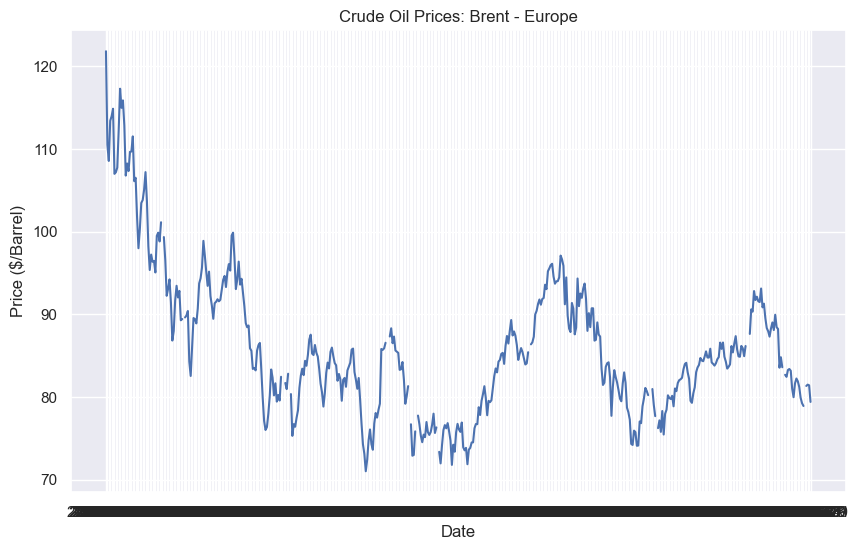

In [4]:
# Plotting
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(brent_oil_price)
plt.title('Crude Oil Prices: Brent - Europe')
plt.xlabel("Date")
plt.ylabel("Price ($/Barrel)")
plt.show()

In [5]:
tweets_sentiment = pd.read_csv('tweets_sentiment.csv', index_col='Unnamed: 0',  lineterminator='\n')
tweets_sentiment['sentiment_score'] = tweets_sentiment['Positive'] - tweets_sentiment['Negative']
tweets_sentiment['label'] = tweets_sentiment[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)\
                                .map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

tweets_topic = pd.read_csv('tweets_topic.csv', index_col='Unnamed: 0')

tweets_df = tweets_sentiment.merge(tweets_topic, how='inner', on='id', suffixes=('', '_copy'))
tweets_df.drop(columns=[col for col in tweets_df.columns if col.endswith('_copy')], inplace=True)
tweets_df = tweets_df[(tweets_df['date'] >= str(start_date)) & (tweets_df['date'] <= str(end_date))]
tweets_df.tail()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral,sentiment_score,label,topic
37685,1730343584572867060,2023-11-30,en,"At least based on today, can't say there's muc...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.044599,0.062963,0.892437,-0.018364,0,3
37686,1730185032914829401,2023-11-30,en,"Is $XOM's ""Death Cross"" a reason for #Energy b...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.053212,0.118022,0.828767,-0.064810,0,3
37687,1730352191548883361,2023-11-30,en,#OOTT #WTI As the #OPEC+ conspiracy collapsed ...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.311486,0.573089,0.115425,-0.261603,-1,0
37688,1730348517313466869,2023-11-30,en,#OOTT #WTI [W1]#OPEC+ got clubbed after its pa...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.025245,0.888074,0.086681,-0.862829,-1,0
37689,1730343562728944032,2023-11-30,en,"#OOTT #WTI ""For now, the outcome does not live...",3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.023566,0.911276,0.065159,-0.887710,-1,0


In [6]:
# Group by date and calculate average sentiment
daily_sentiment = tweets_df.loc[:, ['date', 'label', 'sentiment_score']]
daily_sentiment = daily_sentiment.groupby(['date']).mean()

daily_sentiment.columns = [f'{col}_0' for col in daily_sentiment.columns]
daily_sentiment.head()

,label_0,sentiment_score_0
date,,
2022-07-02,0.333333,0.212321
2022-07-03,-0.264706,-0.217177
2022-07-04,-0.160714,-0.123233
2022-07-05,-0.163934,-0.139811
2022-07-06,-0.191781,-0.177303


In [7]:
# Group by date and topic and calculate average sentiment
daily_topic_sentiment = tweets_df.loc[:, ['date', 'label','topic', 'sentiment_score']]
daily_topic_sentiment['topic'] = daily_topic_sentiment['topic']+1
daily_topic_sentiment = daily_topic_sentiment.groupby(['date', 'topic']).mean()

# Unstack 'topic' to become columns
daily_topic_sentiment = daily_topic_sentiment.unstack(level='topic')

# # Flatten the column MultiIndex resulting from unstack
# daily_topic_sentiment.columns = daily_topic_sentiment.columns.get_level_values(1) + 1
daily_topic_sentiment.columns = daily_topic_sentiment.columns.map('{0[0]}_{0[1]}'.format) 

print(daily_topic_sentiment.head())
print('% days with no tweets by topic')
print(round(daily_topic_sentiment.isna().sum() / len(daily_topic_sentiment) * 100, 2))

             label_1   label_2   label_3   label_4  sentiment_score_1  \
date                                                                    
2022-07-02  0.000000  0.000000  1.000000  1.000000          -0.070201   
2022-07-03 -0.333333 -0.190476 -0.333333 -0.214286          -0.283336   
2022-07-04 -0.095238 -0.187500 -0.375000 -0.090909          -0.129210   
2022-07-05 -0.250000 -0.090909  0.000000  0.000000          -0.233597   
2022-07-06 -0.204545 -0.375000  0.000000 -0.181818          -0.207250   

            sentiment_score_2  sentiment_score_3  sentiment_score_4  
date                                                                 
2022-07-02          -0.004047           0.648673           0.839905  
2022-07-03          -0.173141          -0.271328          -0.135003  
2022-07-04          -0.082532          -0.274846          -0.060758  
2022-07-05          -0.049497           0.061214          -0.010699  
2022-07-06          -0.270887           0.003687          -0.153988 

In [8]:
daily_sentiment = pd.concat([daily_sentiment, daily_topic_sentiment], axis=1)
daily_sentiment.head()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2022-07-02,0.333333,0.212321,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.264706,-0.217177,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.160714,-0.123233,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.163934,-0.139811,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699
2022-07-06,-0.191781,-0.177303,-0.204545,-0.375000,0.000000,-0.181818,-0.207250,-0.270887,0.003687,-0.153988


In [9]:
features_df = daily_sentiment.fillna(0)
features_df = features_df.rolling(window=7).mean()
features_df.tail()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2024-05-27,-0.175591,-0.129427,-0.266826,0.092965,-0.186134,-0.123016,-0.250305,0.119174,-0.135923,-0.059630
2024-05-28,-0.130983,-0.101295,-0.169547,0.140584,-0.200420,-0.099206,-0.172202,0.124708,-0.133484,-0.043741
2024-05-29,-0.094890,-0.076828,-0.118527,0.133163,-0.133193,-0.084921,-0.117914,0.102768,-0.082155,-0.049314
2024-05-30,-0.074111,-0.064200,-0.109173,0.151020,-0.113550,-0.016893,-0.115058,0.098831,-0.064777,0.002360
2024-05-31,-0.061720,-0.051545,-0.110364,0.133163,0.017402,-0.045465,-0.115020,0.067778,0.065372,-0.001629


In [10]:
df = pd.merge(brent_oil_price, features_df, left_index=True, right_index=True)
df.dropna(inplace=True)
df.head()

,DCOILBRENTEU,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,,
2022-07-08,113.95,-0.083189,-0.087374,-0.133678,-0.156269,0.001984,0.063080,-0.154155,-0.116261,0.001749,0.053397
2022-07-11,114.85,-0.122250,-0.115398,-0.129121,-0.182772,-0.103458,-0.043697,-0.149743,-0.138650,-0.068767,-0.043274
2022-07-12,106.98,-0.129643,-0.116865,-0.141026,-0.190193,-0.046315,-0.100840,-0.155559,-0.131345,-0.052966,-0.074022
2022-07-13,107.17,-0.113235,-0.104410,-0.123234,-0.148526,-0.046315,-0.092723,-0.136242,-0.109364,-0.059824,-0.067986
2022-07-14,107.74,-0.129420,-0.117771,-0.131021,-0.181493,-0.066156,-0.102927,-0.140339,-0.134836,-0.094067,-0.068368


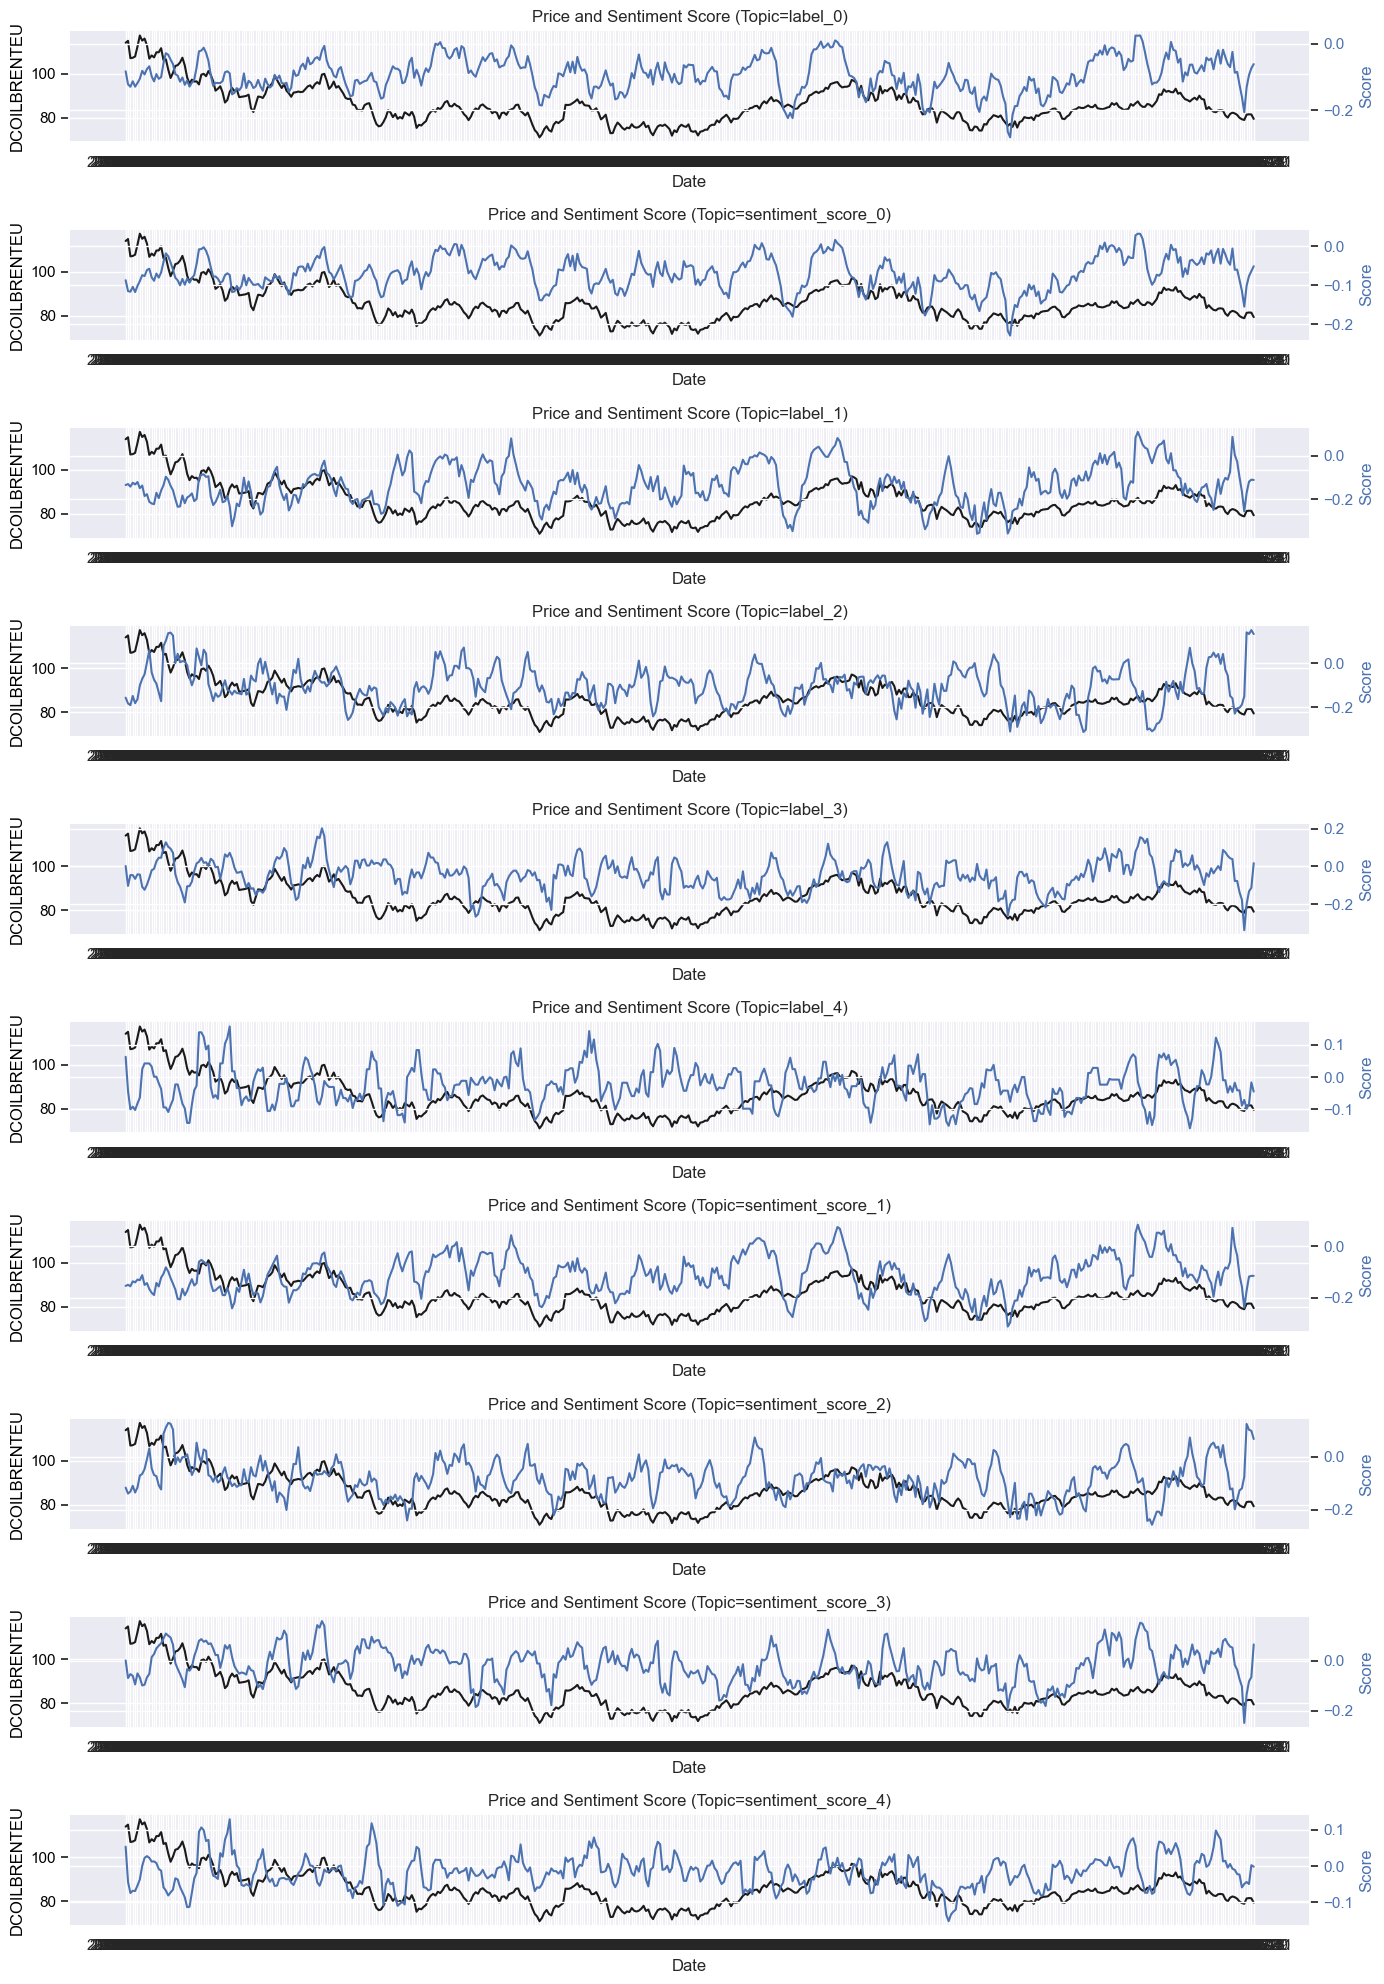

In [11]:
# Create subplots
fig, axs = plt.subplots(features_df.shape[1], 1, figsize=(14, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each feature against the target on different y-axes
for i in range(1, df.shape[1]):
    col = df.columns[i]
    ax1 = axs[i-1]
    ax2 = ax1.twinx()
    
    ax1.plot(df['DCOILBRENTEU'], 'k-', label='Price')
    ax2.plot(df[col], 'b-', label=f'Topic {col}')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DCOILBRENTEU', color='black')
    ax2.set_ylabel('Score', color='b')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    ax1.set_title(f'Price and Sentiment Score (Topic={col})')

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Check

In [12]:
# Define helper function to check for stationarity
def check_stationarity(df, column, lags):
    # Drop NAs if any
    # df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=column)
    df = df.dropna(subset=column)

    plot_acf(df[column], lags=lags)
    plt.title(f"Autocorrelation Function (ACF) - {column}")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

    adftest = adfuller(df[column], maxlag=lags, autolag='AIC', regression='ct')
    if adftest[1] < 0.05:
        print("ADF Test Conclusion: Stationary")
    else:
        print("ADF Test Conclusion: Non-stationary")
    print("------------------------------------")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    
    return 

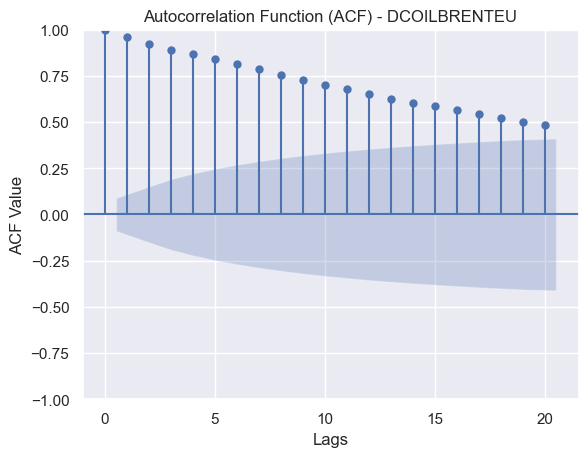

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -3.3583495803520456
P-Value: 0.05720649018199399
Number of lags: 14
Number of observations: 463
Critical Values: {'1%': -3.978457095856303, '5%': -3.4200151141722914, '10%': -3.1326529842791313}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [13]:
check_stationarity(df, 'DCOILBRENTEU', 20)

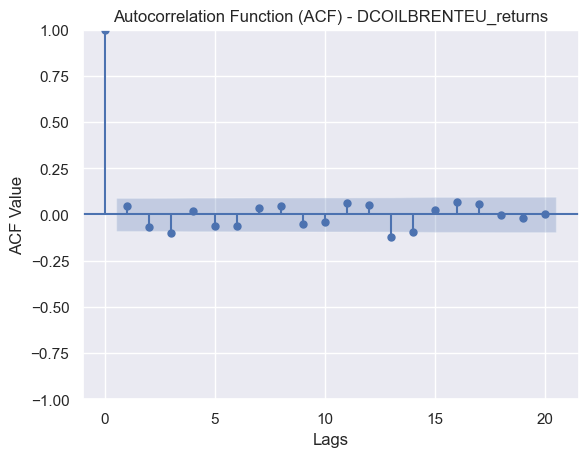

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -7.064727981669803
P-Value: 1.0080558865818688e-08
Number of lags: 13
Number of observations: 463
Critical Values: {'1%': -3.978457095856303, '5%': -3.4200151141722914, '10%': -3.1326529842791313}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [14]:
# Calculate first differences
df['DCOILBRENTEU_returns'] = df['DCOILBRENTEU'].pct_change(1)

check_stationarity(df, 'DCOILBRENTEU_returns', 20)

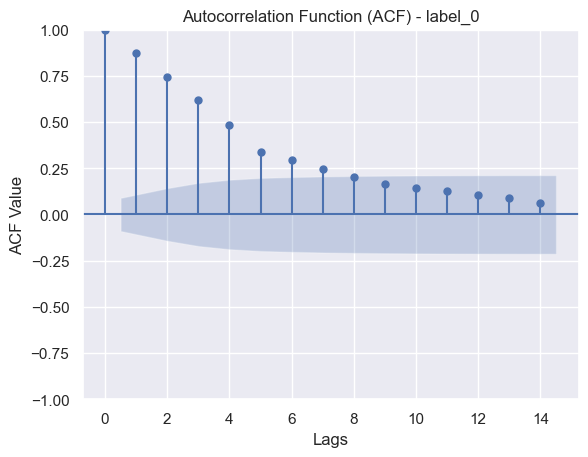

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.26984476631878
P-Value: 0.0035030666959504956
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


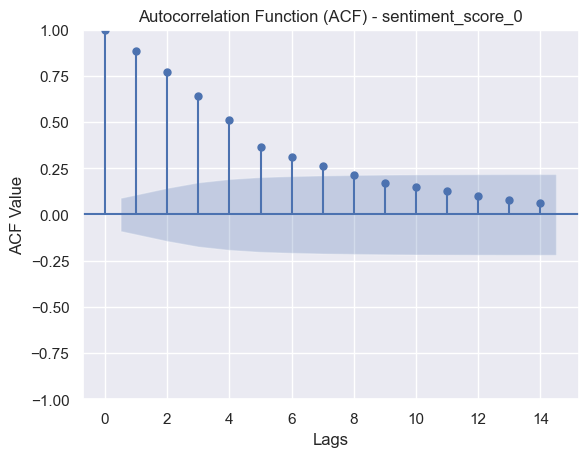

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.52848681355386
P-Value: 0.001355438845088488
Number of lags: 11
Number of observations: 466
Critical Values: {'1%': -3.978329489428181, '5%': -3.419953518250008, '10%': -3.1326167935758216}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


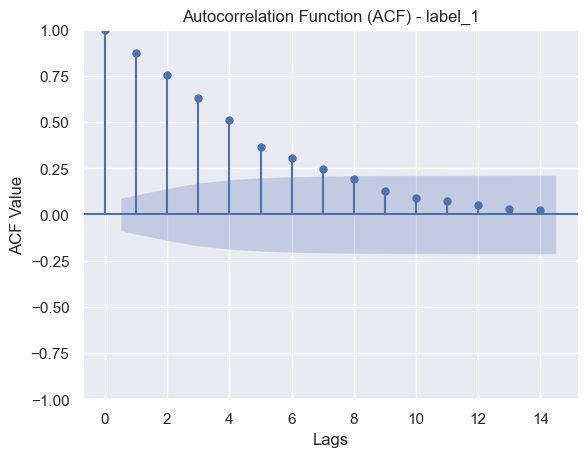

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.698311710796727
P-Value: 0.0007026294842310503
Number of lags: 11
Number of observations: 466
Critical Values: {'1%': -3.978329489428181, '5%': -3.419953518250008, '10%': -3.1326167935758216}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


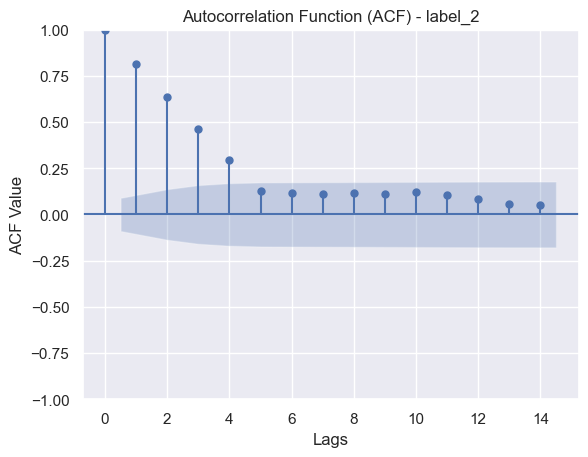

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.426346750010761
P-Value: 0.0019870929322187768
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


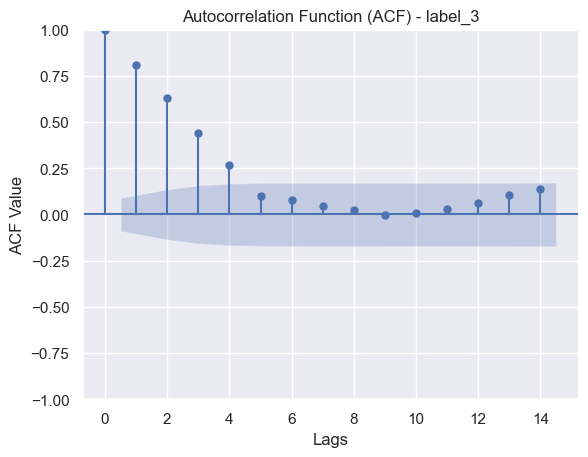

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.538041251674263
P-Value: 0.0013071481987591473
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


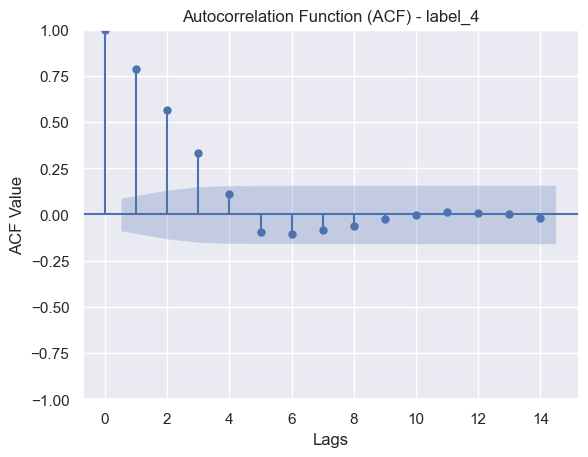

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.946734844953857
P-Value: 2.840691615862435e-06
Number of lags: 14
Number of observations: 463
Critical Values: {'1%': -3.978457095856303, '5%': -3.4200151141722914, '10%': -3.1326529842791313}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


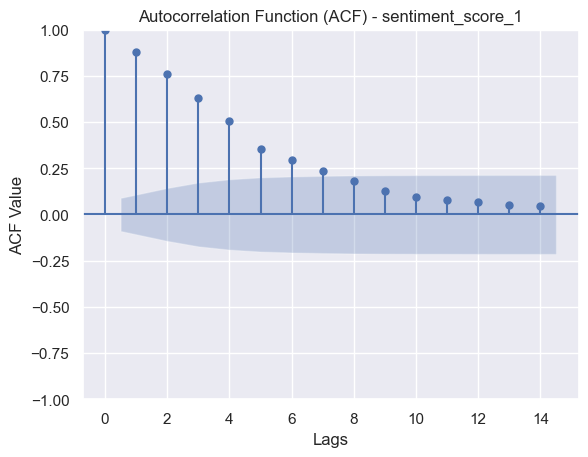

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.403408004612615
P-Value: 0.0021624523743698667
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


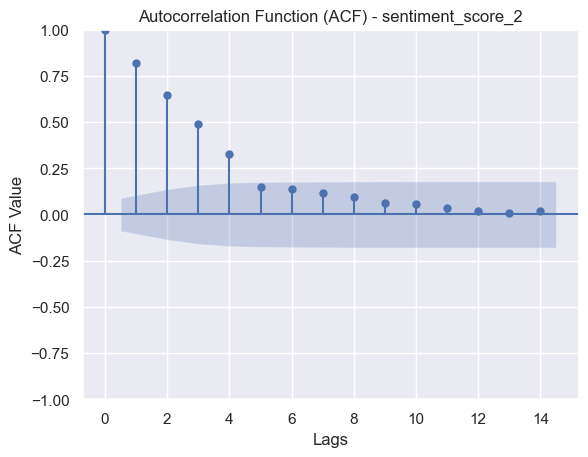

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.773997872030777
P-Value: 0.0005200085420264204
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


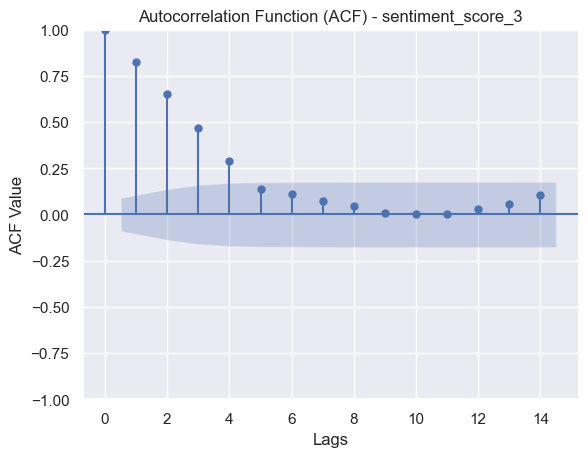

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.7527575989779445
P-Value: 0.0005661211064801886
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


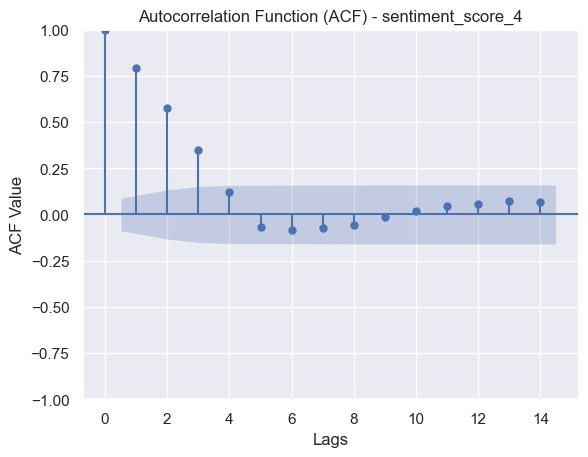

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.094069208914411
P-Value: 0.00013820150907875662
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [17]:
for col in features_df.columns:
    check_stationarity(df, col, 14)

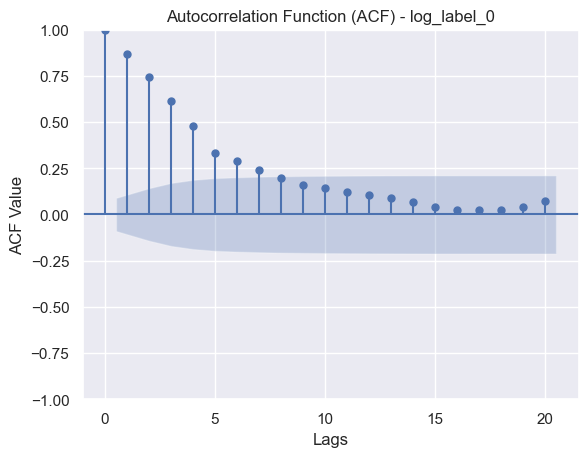

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.039345940340179
P-Value: 0.0077252184852535
Number of lags: 15
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


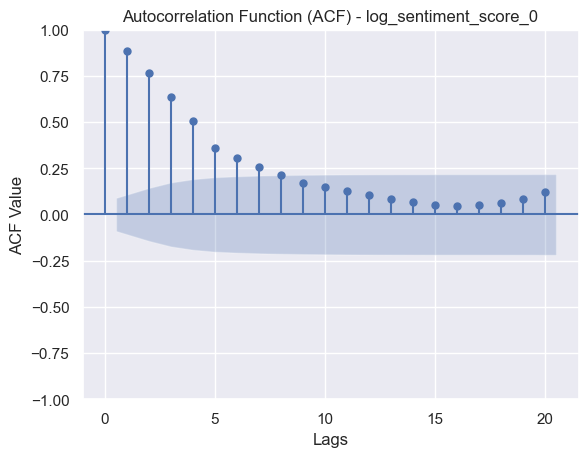

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.521490569116113
P-Value: 0.0013918537200560412
Number of lags: 11
Number of observations: 466
Critical Values: {'1%': -3.978329489428181, '5%': -3.419953518250008, '10%': -3.1326167935758216}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


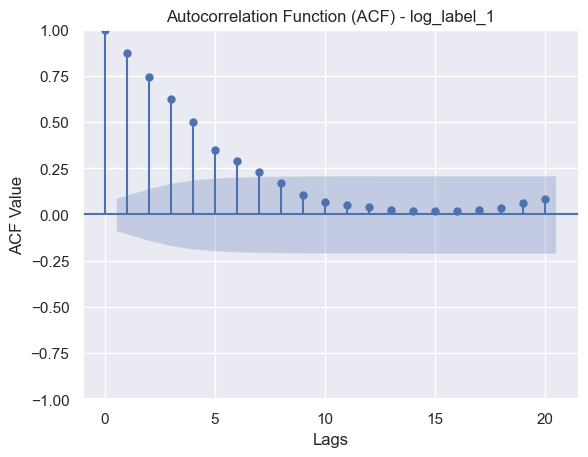

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.557034849494197
P-Value: 0.001215898496463644
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


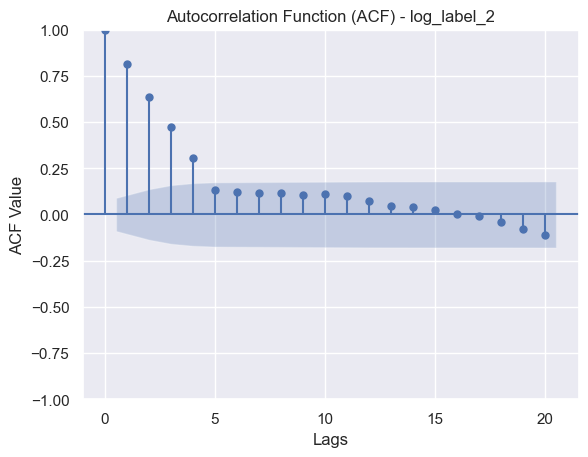

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.566497148554116
P-Value: 0.0011727016080927805
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


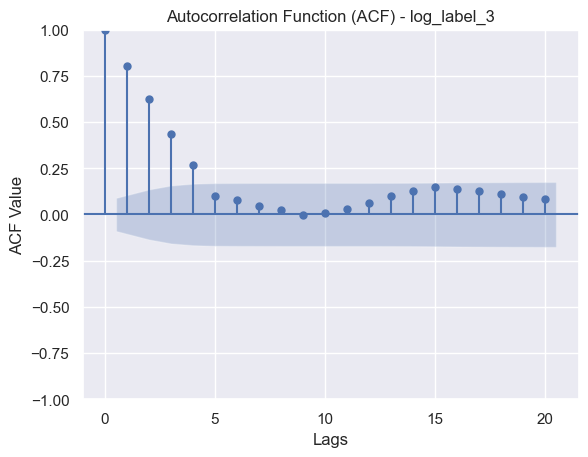

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.587453582253644
P-Value: 0.0010821049678837328
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


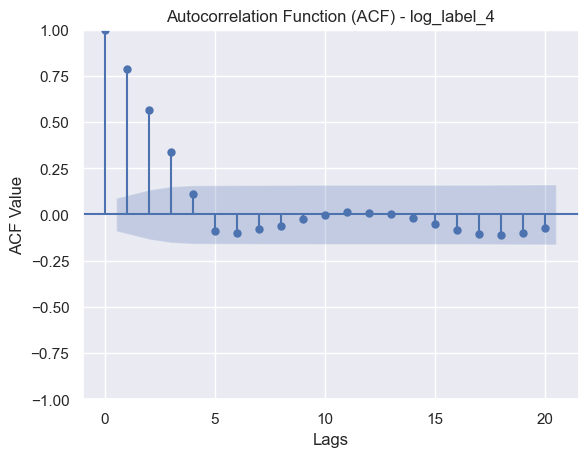

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.3768238053096695
P-Value: 4.016918175002051e-05
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


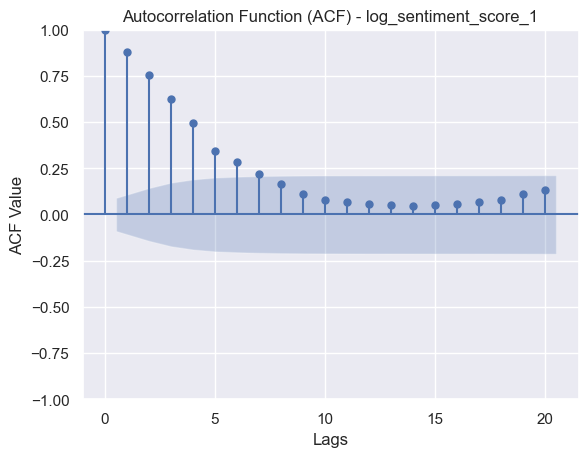

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.422686533028502
P-Value: 0.0020141565470633673
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


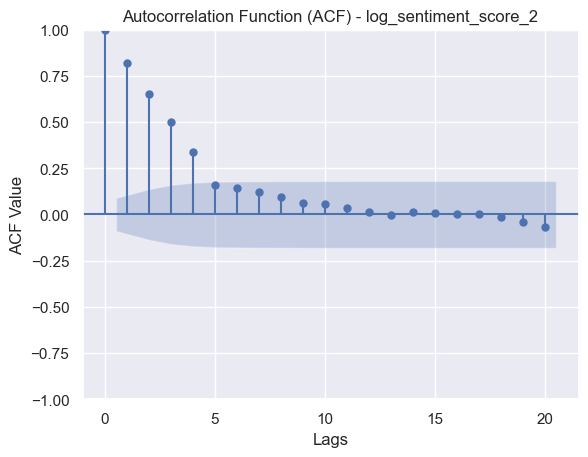

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.84281099121209
P-Value: 0.00039385095513758096
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


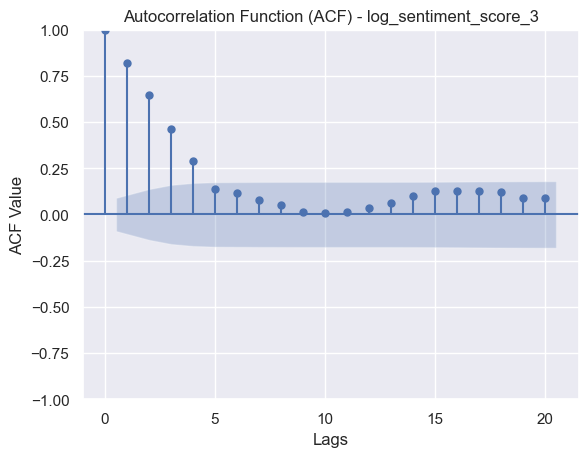

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.758205238160712
P-Value: 0.0005539385002738172
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


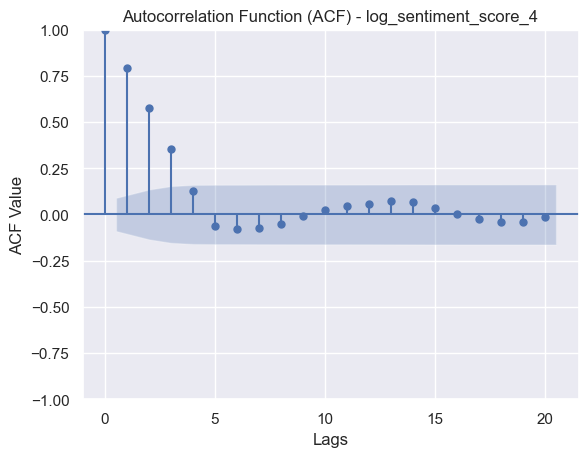

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.069273521208377
P-Value: 0.00015358682294337535
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [139]:
for col in features_df.columns:
    try:
        new_column_name = f'log_{col}'
        df[new_column_name] = np.log(df[col]+1)
        check_stationarity(df, new_column_name, 20)
    except:
        continue

## Granger Causality Check

In [18]:
def check_granger_causality(df, target, features, maxlag, test='ssr_chi2test'):
    granger_df = pd.DataFrame()
    granger_df['lag'] = [i for i in range(1,maxlag+1)]
    for feature in features:
        res = grangercausalitytests(df[[target, feature]], maxlag=maxlag)
        p_value = [res.get(i)[0].get(test)[1] for i in res.keys()]
        # for i in res.keys():
        #     p_value.append()
        col_name = f'{feature}_causes_{target}'
        granger_df[col_name] = p_value

    plt.figure(figsize=(16,9))
    for y in granger_df.columns[1:]:   
        plt.plot(granger_df['lag'],granger_df[y],linewidth=3, label=y)
    plt.axhline(0.05)
    # plt.axhline(0.10)
    plt.xlabel('lag')
    plt.legend()
    plt.show()




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8870  , p=0.3468  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=0.8927  , p=0.3448  , df=1
likelihood ratio test: chi2=0.8918  , p=0.3450  , df=1
parameter F test:         F=0.8870  , p=0.3468  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9342  , p=0.1457  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=3.9096  , p=0.1416  , df=2
likelihood ratio test: chi2=3.8936  , p=0.1427  , df=2
parameter F test:         F=1.9342  , p=0.1457  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4281  , p=0.2338  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=4.3486  , p=0.2262  , df=3
likelihood ratio test: chi2=4.3288  , p=0.2281  , df=3
parameter F test:         F=1.4281  , p=0.2338  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5126  , p=0.1973  

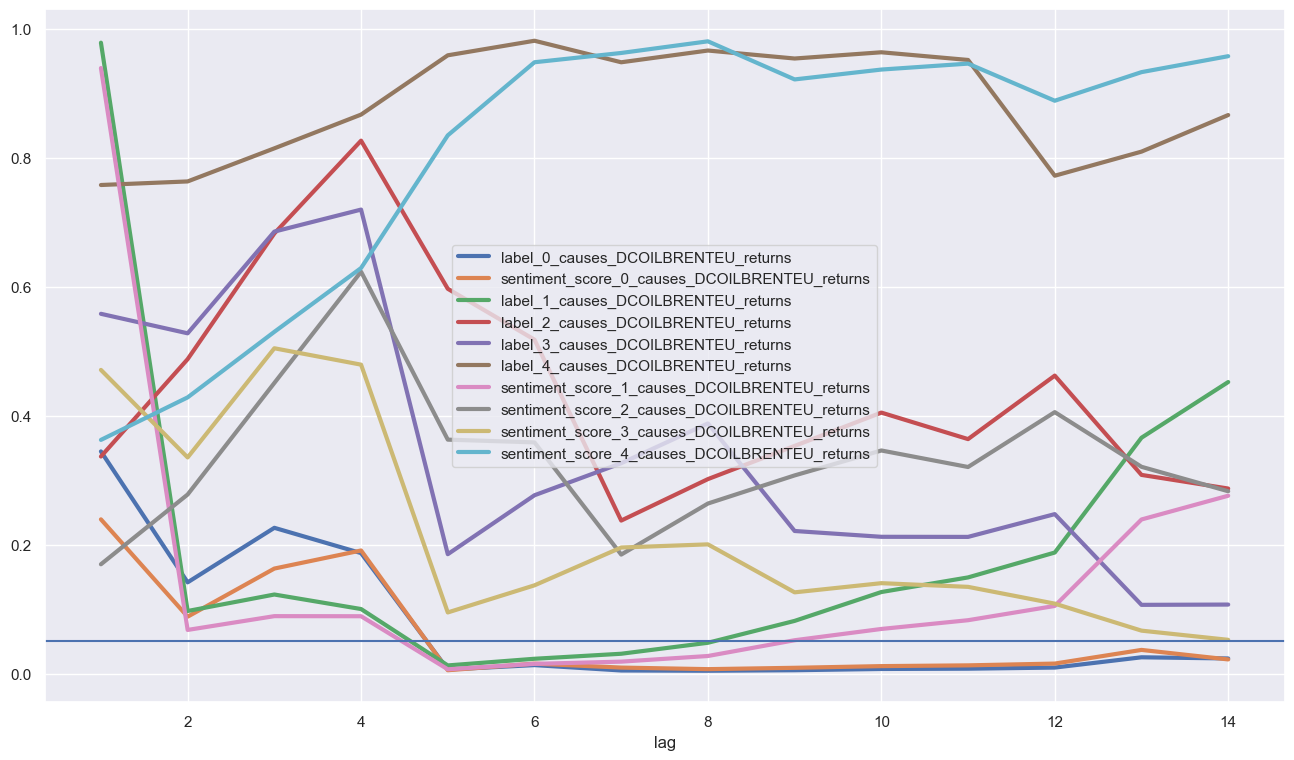

In [19]:
model_df = df.dropna()

selected_target = 'DCOILBRENTEU_returns'
# selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('sentiment_score')]
# selected_features = [f'log_{col}' for col in features_df.columns if col.startswith('sentiment_score')]
selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0039  , p=0.9500  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=0.0040  , p=0.9499  , df=1
likelihood ratio test: chi2=0.0040  , p=0.9499  , df=1
parameter F test:         F=0.0039  , p=0.9500  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2518  , p=0.2869  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=2.5302  , p=0.2822  , df=2
likelihood ratio test: chi2=2.5235  , p=0.2832  , df=2
parameter F test:         F=1.2518  , p=0.2869  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9062  , p=0.4379  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=2.7593  , p=0.4302  , df=3
likelihood ratio test: chi2=2.7513  , p=0.4316  , df=3
parameter F test:         F=0.9062  , p=0.4379  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4272  , p=0.2238  

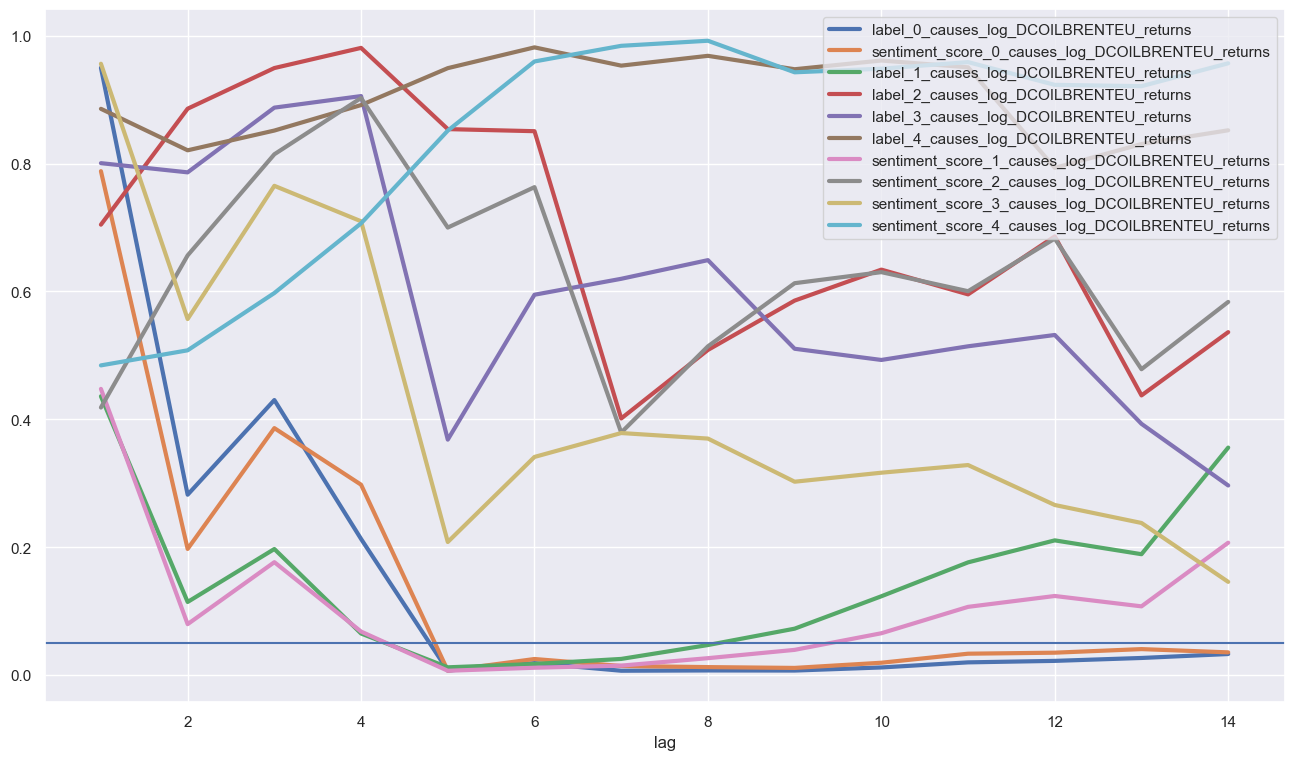

In [142]:
selected_target = 'log_DCOILBRENTEU_returns'
# selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('label')]
selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)

In [21]:
from statsmodels.tsa.api import VAR

model_df = df[['DCOILBRENTEU_returns', 'sentiment_score_0', 'sentiment_score_1']]
model_df.dropna(inplace=True)

model = VAR(model_df)
maxlag = 7

for i in range(1,maxlag+1):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -23.27801908039552
BIC :  -23.173008546255232
FPE :  7.771149773432277e-11
HQIC:  -23.23672718563332 

Lag Order = 2
AIC :  -23.318602961244068
BIC :  -23.134540622539376
FPE :  7.46211930832539e-11
HQIC:  -23.246220183318364 

Lag Order = 3
AIC :  -23.360963338724382
BIC :  -23.097595786718365
FPE :  7.152711168220792e-11
HQIC:  -23.257384509341748 

Lag Order = 4
AIC :  -23.359748964909777
BIC :  -23.016821438163085
FPE :  7.16156547402459e-11
HQIC:  -23.224868344801887 

Lag Order = 5
AIC :  -23.419147213509813
BIC :  -22.996403587857046
FPE :  6.748813879800033e-11
HQIC:  -23.252858488188433 

Lag Order = 6
AIC :  -23.647745390282942
BIC :  -23.144928168714078
FPE :  5.369968539343576e-11
HQIC:  -23.44994166575488 

Lag Order = 7
AIC :  -23.634968895267946
BIC :  -23.05181919771375
FPE :  5.439420427168617e-11
HQIC:  -23.405542693709545 



/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_83908/1572728942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
results = model.fit(maxlags=7, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, Aug, 2024
Time:                     00:32:43
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.1449
Nobs:                     471.000    HQIC:                  -23.4499
Log likelihood:           3621.08    FPE:                5.36997e-11
AIC:                     -23.6477    Det(Omega_mle):     4.76921e-11
--------------------------------------------------------------------
Results for equation DCOILBRENTEU_returns
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.002125         0.002182           -0.974           0.330
L1.DCOILBRENTEU_returns        -0.017440         0.049699           -0.351           0.726
L1.se

In [23]:
# Select the optimal lag order
lag_order_selection = model.select_order(maxlags=7)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -20.38      -20.35   1.414e-09      -20.37
1      -23.29     -23.19*   7.662e-11      -23.25
2      -23.31      -23.13   7.514e-11      -23.24
3      -23.36      -23.09   7.173e-11      -23.25
4      -23.36      -23.01   7.169e-11      -23.22
5      -23.42      -23.00   6.747e-11      -23.25
6     -23.64*      -23.14  5.388e-11*     -23.45*
7      -23.63      -23.05   5.439e-11      -23.41
-------------------------------------------------


In [24]:
model_df.head()

lags = range(1, 7)  # Just two lags for demonstration.

model_df = model_df.assign(**{
                f'{col} (t-{lag})': model_df[col].shift(lag)
                for lag in lags
                for col in model_df.columns[1:]
            })

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin
# import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


In [26]:
# Sort data by date
model_df.dropna(inplace=True)
model_df = model_df.sort_values('date')

# Split the data
train_set, test_set= np.split(model_df, [int(.67 *len(model_df))])
X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:, 0] 
X_test, y_test = test_set.iloc[:, 1:], test_set.iloc[:, 0] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [28]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [29]:
# For ARIMA, we need a time series dataset. Here we'll use y directly as a placeholder.
arima = ARIMA(y_train, order=(5,1,0))
arima_fit = arima.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

In [30]:
# ARIMAX requires the statsmodels library's SARIMAX implementation.
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax = SARIMAX(y_train, exog=X_train, order=(5,1,0))
arimax_fit = arimax.fit(disp=False)
y_pred_arimax = arimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [31]:
ada = AdaBoostRegressor(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [32]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

models = {
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr,
    "ARIMA": y_pred_arima,
    "ARIMAX": y_pred_arimax,
    # "SVR-Li": y_pred_svr_li,
    "AdaBoost": y_pred_ada
}

for name, y_pred in models.items():
    mse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Random Forest - MSE: 0.0003, MAE: 0.0141, R2: 0.0009
SVR - MSE: 0.0004, MAE: 0.0157, R2: -0.2437
ARIMA - MSE: 0.0004, MAE: 0.0165, R2: -0.3529
ARIMAX - MSE: 0.0004, MAE: 0.0147, R2: -0.1218
AdaBoost - MSE: 0.0003, MAE: 0.0140, R2: -0.0559


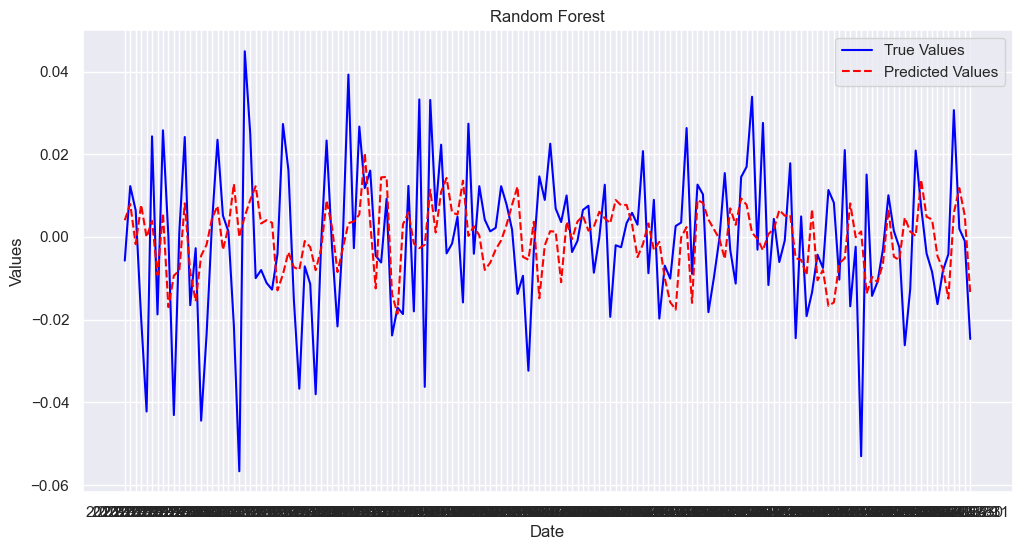

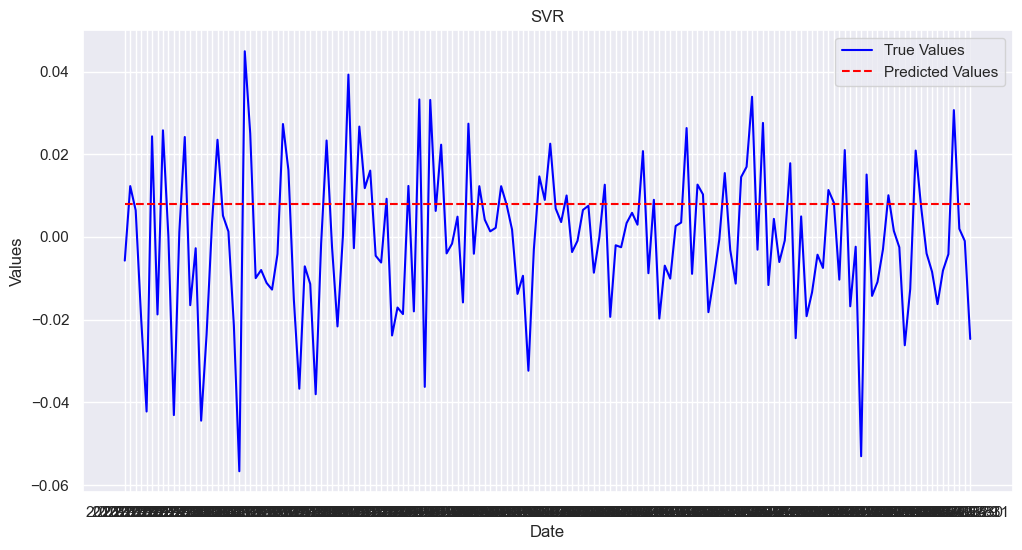

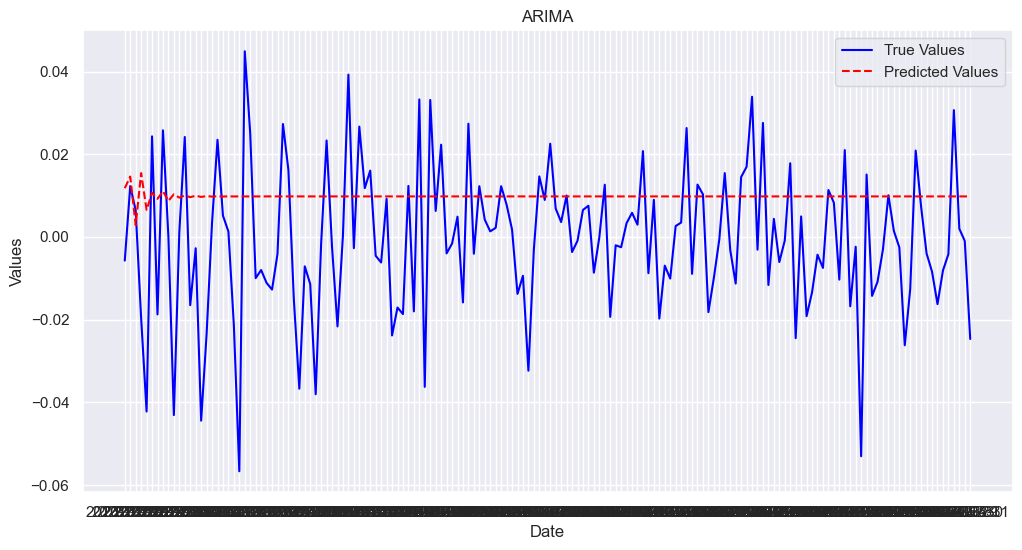

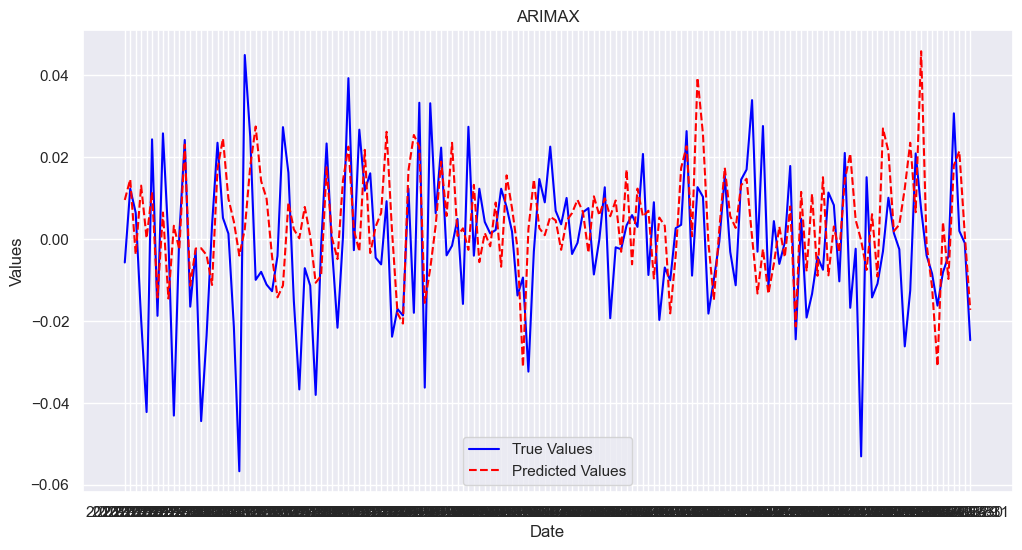

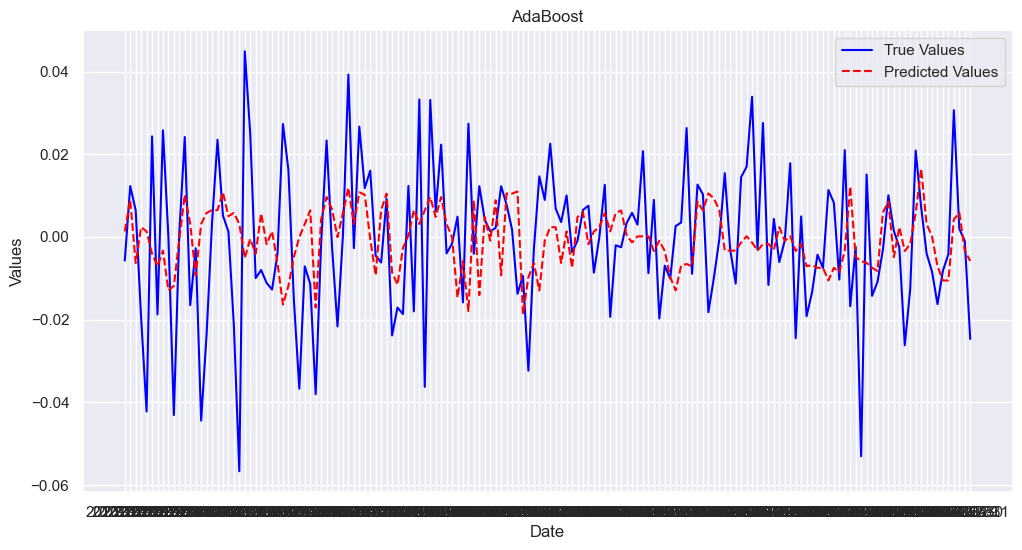

In [33]:
# Define a function to plot true vs. predicted values as line plots with a date index
def plot_true_vs_pred_line(dates, y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

y_test_dates = test_set.index

# Plotting the results for each model
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_rf, "Random Forest")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr, "SVR")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arima, "ARIMA")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arimax, "ARIMAX")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr_li, "SVR-Li")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_ada, "AdaBoost")


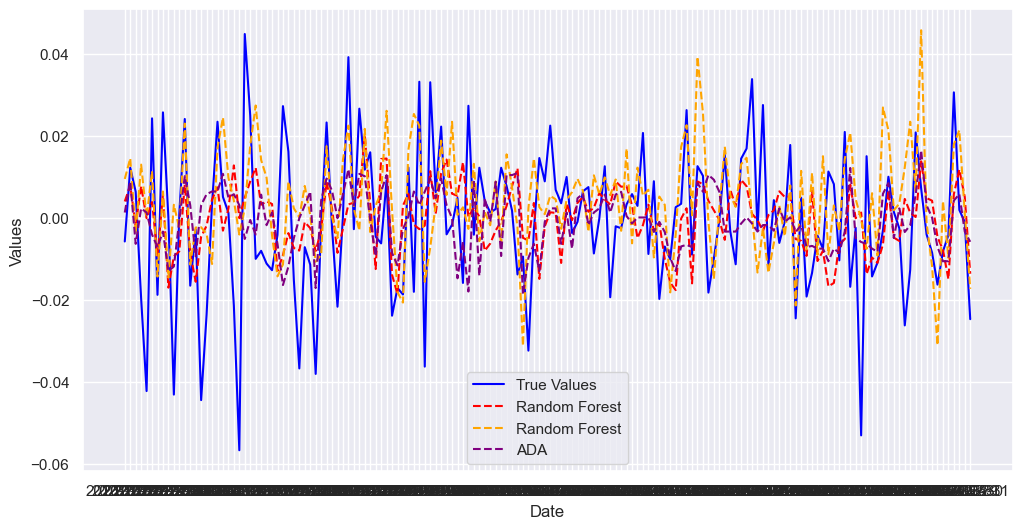

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='True Values', color='blue')
plt.plot(y_test_dates, y_pred_rf, label='Random Forest', color='red', linestyle='--')
plt.plot(y_test_dates, y_pred_arimax, label='Random Forest', color='orange', linestyle='--')
plt.plot(y_test_dates, y_pred_ada, label='ADA', color='purple', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import joblib

joblib.dump(rf, "models/random_forest.joblib")
joblib.dump(svr, 'models/svr.joblib')
joblib.dump(arima, 'models/arima.joblib')
joblib.dump(arimax, 'models/arimax.joblib')
joblib.dump(ada, 'models/adaboost_model.joblib')

['models/adaboost_model.joblib']